# IV and Panel IV
---

In [1]:
import pandas as pd
import numpy as np

import statsmodels.api as sm
from linearmodels.iv import IV2SLS
from linearmodels.iv import IVGMM
from linearmodels import PooledOLS
from linearmodels import PanelOLS
from linearmodels.iv import compare

import matplotlib.pyplot as plt
import seaborn as sns

from linearmodels.datasets import card

sns.set_style("darkgrid")
sns.set(rc={'figure.figsize':(12,9)})

pd.set_option('display.max_rows', 100)

# 1. Instrumental Variables
---
- This example combines (with edits and comments by Christopher Lo):
    - Rachel Meager's EC333 Lent Term R code 
    - https://bashtage.github.io/linearmodels/doc/iv/examples/basic-examples.html 

In [2]:
# Import data

college_data = card.load()
print(card.DESCR)


D. Card (1995), "Using Geographic Variation in College Proximity to Estimate
the Return to Schooling," in Aspects of Labour Market Behavior:  Essays in
Honour of John Vanderkamp.  Ed. L.N. Christophides, E.K. Grant, and R.
Swidinsky, 201-222.  Toronto: University of Toronto Press.

id                       person identifier
nearc2                   =1 if near 2 yr college, 1966
nearc4                   =1 if near 4 yr college, 1966
educ                     years of schooling, 1976
age                      in years
fatheduc                 father's schooling
motheduc                 mother's schooling
weight                   NLS sampling weight, 1976
momdad14                 =1 if live with mom, dad at 14
sinmom14                 =1 if with single mom at 14
step14                   =1 if with step parent at 14
reg661                   =1 for region 1, 1966
reg662                   =1 for region 2, 1966
reg663                   =1 for region 3, 1966
reg664                   =1 for regi

In [3]:
# Add a constant column

college_data = sm.add_constant(college_data)
college_data

,const,id,nearc2,nearc4,educ,age,fatheduc,motheduc,weight,momdad14,...,smsa66,wage,enroll,KWW,IQ,married,libcrd14,exper,lwage,expersq
0,1.0,2,0,0,7,29,NaN,NaN,158413,1,...,1,548,0,15.0,NaN,1.0,0.0,16,6.306275,256
1,1.0,3,0,0,12,27,8.0,8.0,380166,1,...,1,481,0,35.0,93.0,1.0,1.0,9,6.175867,81
2,1.0,4,0,0,12,34,14.0,12.0,367470,1,...,1,721,0,42.0,103.0,1.0,1.0,16,6.580639,256
3,1.0,5,1,1,11,27,11.0,12.0,380166,1,...,1,250,0,25.0,88.0,1.0,1.0,10,5.521461,100
4,1.0,6,1,1,12,34,8.0,7.0,367470,1,...,1,729,0,34.0,108.0,1.0,0.0,16,6.591674,256
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3005,1.0,218,0,1,12,25,8.0,12.0,82135,1,...,0,335,0,15.0,NaN,1.0,0.0,7,5.814130,49
3006,1.0,219,0,1,13,34,NaN,NaN,88765,1,...,0,481,0,43.0,NaN,1.0,1.0,15,6.175867,225
3007,1.0,220,0,1,12,24,11.0,NaN,89271,0,...,0,500,0,25.0,109.0,1.0,0.0,6,6.214608,36
3008,1.0,221,0,1,12,31,NaN,NaN,110376,1,...,0,713,0,32.0,107.0,1.0,1.0,13,6.569481,169


In [4]:
# Seperate out variables

dep = ['wage']
endog = ['educ']
exog = ['const','exper','expersq','black','smsa','south','smsa66','reg662',
       'reg663','reg664','reg665','reg666','reg667','reg668','reg669']
instr = ['nearc4']

# Select relevant columns and drop rows with missing values

college_data = college_data[dep +exog+endog+ instr].dropna()
college_data

,wage,const,exper,expersq,black,smsa,south,smsa66,reg662,reg663,reg664,reg665,reg666,reg667,reg668,reg669,educ,nearc4
0,548,1.0,16,256,1,1,0,1,0,0,0,0,0,0,0,0,7,0
1,481,1.0,9,81,0,1,0,1,0,0,0,0,0,0,0,0,12,0
2,721,1.0,16,256,0,1,0,1,0,0,0,0,0,0,0,0,12,0
3,250,1.0,10,100,0,1,0,1,1,0,0,0,0,0,0,0,11,1
4,729,1.0,16,256,0,1,0,1,1,0,0,0,0,0,0,0,12,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3005,335,1.0,7,49,0,0,1,0,0,0,0,0,1,0,0,0,12,1
3006,481,1.0,15,225,0,1,1,0,0,0,0,0,1,0,0,0,13,1
3007,500,1.0,6,36,0,0,1,0,0,0,0,0,1,0,0,0,12,1
3008,713,1.0,13,169,0,0,1,0,0,0,0,0,1,0,0,0,12,1


# 1.1. Naive OLS Model

In [5]:
# Regress wages on education plus controls

reg_wages_education = sm.OLS(np.log(college_data[dep]), college_data[endog + exog]).fit()
reg_wages_education.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                   wage   R-squared:                       0.300
Model:                            OLS   Adj. R-squared:                  0.296
Method:                 Least Squares   F-statistic:                     85.48
Date:                Thu, 11 Mar 2021   Prob (F-statistic):          1.74e-218
Time:                        11:04:08   Log-Likelihood:                -1288.8
No. Observations:                3010   AIC:                             2610.
Df Residuals:                    2994   BIC:                             2706.
Df Model:                          15                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
educ           0.0747      0.003     21.351      0.000       0.068       0.082
const          4.6208      0.074     62.248      0.000       4.475       4.766
exper          0.0848      0.007     12.806      0.000       0.072       0.098
expersq       -0.0023      0.000     -7.223      0.000      -0.003      -0.002
black         -0.1990      0.018    -10.906      0.000      -0.235      -0.163
smsa           0.1364      0.020      6.785      0.000       0.097       0.176
south         -0.1480      0.026     -5.695      0.000      -0.199      -0.097
smsa66         0.0262      0.019      1.349      0.177      -0.012       0.064
reg662         0.0964      0.036      2.684      0.007       0.026       0.167
reg663         0.1445      0.035      4.115      0.000       0.076       0.213
reg664         0.0551      0.042      1.322      0.186      -0.027       0.137
reg665         0.1280      0.042      3.060      0.002       0.046       0.210
reg666         0.1405      0.045      3.106      0.002       0.052       0.229
reg667         0.1180      0.045      2.633      0.008       0.030       0.206
reg668        -0.0564      0.051     -1.101      0.271      -0.157       0.044
reg669         0.1186      0.039      3.054      0.002       0.042       0.195
==============================================================================
Omnibus:                       59.717   Durbin-Watson:                   1.880
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               71.222
Skew:                          -0.282   Prob(JB):                     3.42e-16
Kurtosis:                       3.501   Cond. No.                     1.97e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.97e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

# 1.2. Two-steps Manual IV

- The following example shows the dangers of incorrectly specifying IV regressions.

## 1.2.1. First Stage

In [6]:
# Regress education levels on instrument
# This regression is problematic! We find out why in Section 1.4.

fs_education_on_distance = sm.OLS(college_data[endog], college_data[instr + ['const']]).fit()
fs_education_on_distance.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                   educ   R-squared:                       0.021
Model:                            OLS   Adj. R-squared:                  0.020
Method:                 Least Squares   F-statistic:                     63.91
Date:                Thu, 11 Mar 2021   Prob (F-statistic):           1.84e-15
Time:                        11:04:08   Log-Likelihood:                -7202.7
No. Observations:                3010   AIC:                         1.441e+04
Df Residuals:                    3008   BIC:                         1.442e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
nearc4         0.8290      0.104      7.994      0.000       0.626       1.032
const         12.6980      0.086    148.269      0.000      12.530      12.866
==============================================================================
Omnibus:                       26.936   Durbin-Watson:                   1.626
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               28.373
Skew:                          -0.204   Prob(JB):                     6.90e-07
Kurtosis:                       3.243   Cond. No.                         3.31
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

## 1.2.2. Second Stage

In [7]:
# Compute predicted education level from instrument
# Note: linearmodel's does not have an equivalent to R's predict() function

params = fs_education_on_distance.params
educ_hat = params["nearc4"]*college_data["nearc4"] + params["const"]
college_data['pred_educ'] = educ_hat
college_data['pred_educ']

0       12.698015
1       12.698015
2       12.698015
3       13.527034
4       13.527034
          ...    
3005    13.527034
3006    13.527034
3007    13.527034
3008    13.527034
3009    13.527034
Name: pred_educ, Length: 3010, dtype: float64

In [8]:
# Regress wages on instrument and controls
# This regression is problematic! We find out why in Section 1.4.

second_stage_wage_education = sm.OLS(np.log(college_data[dep]), college_data[exog + ['pred_educ']]).fit()
second_stage_wage_education.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                   wage   R-squared:                       0.195
Model:                            OLS   Adj. R-squared:                  0.191
Method:                 Least Squares   F-statistic:                     48.25
Date:                Thu, 11 Mar 2021   Prob (F-statistic):          9.82e-129
Time:                        11:04:08   Log-Likelihood:                -1499.4
No. Observations:                3010   AIC:                             3031.
Df Residuals:                    2994   BIC:                             3127.
Df Model:                          15                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          5.2098      0.290     17.942      0.000       4.640       5.779
exper          0.0540      0.007      7.791      0.000       0.040       0.068
expersq       -0.0022      0.000     -6.540      0.000      -0.003      -0.002
black         -0.2698      0.019    -13.990      0.000      -0.308      -0.232
smsa           0.1647      0.022      7.637      0.000       0.122       0.207
south         -0.1515      0.028     -5.436      0.000      -0.206      -0.097
smsa66         0.0219      0.022      1.006      0.315      -0.021       0.065
reg662         0.0904      0.038      2.349      0.019       0.015       0.166
reg663         0.1446      0.038      3.832      0.000       0.071       0.219
reg664         0.0653      0.045      1.461      0.144      -0.022       0.153
reg665         0.1104      0.045      2.457      0.014       0.022       0.199
reg666         0.1231      0.049      2.523      0.012       0.027       0.219
reg667         0.1061      0.048      2.199      0.028       0.012       0.201
reg668        -0.0142      0.055     -0.258      0.797      -0.122       0.094
reg669         0.1355      0.042      3.252      0.001       0.054       0.217
pred_educ      0.0507      0.022      2.327      0.020       0.008       0.094
==============================================================================
Omnibus:                       37.068   Durbin-Watson:                   1.844
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               43.554
Skew:                          -0.207   Prob(JB):                     3.49e-10
Kurtosis:                       3.419   Cond. No.                     5.15e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 5.15e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

# 1.3. One-step 2SLS

## Comments:
- In Chp 4.6. of Mostly Harmless Econometrics, Angrist and Prische warn against manual IV unless in "emergencies on the planet Krikkit where all your software licenses are expired".
- Thanfully Python and all the libraries used in this class are free and open source!
- For the sake of avoiding the potential 2-step manual IV problems (see Mostly Harmless Metrics for details):
    - Understated standard errors in 2nd stage (Chp 4.6.1.)
    - Covariance ambivalence (Chp 4.6.2.)
- I will only show the code for correctly implementing 1-step IV 2SLS.

In [9]:
# Using the formula API

formula = "np.log(wage) ~ 1 + exper + expersq + black + smsa + south + smsa66 + reg662 + reg663 + reg664 + \
           reg665 + reg666 + reg667 + reg668 + reg669 + [educ ~ nearc4]"
IV_wages_education_res = IV2SLS.from_formula(formula, college_data).fit()
IV_wages_education_res

IV-2SLS Estimation Summary                          
==============================================================================
Dep. Variable:           np.log(wage)   R-squared:                      0.2382
Estimator:                    IV-2SLS   Adj. R-squared:                 0.2343
No. Observations:                3010   F-statistic:                    840.83
Date:                Thu, Mar 11 2021   P-value (F-stat)                0.0000
Time:                        11:04:08   Distribution:                 chi2(15)
Cov. Estimator:                robust                                         
                                                                              
                             Parameter Estimates                              
==============================================================================
            Parameter  Std. Err.     T-stat    P-value    Lower CI    Upper CI
------------------------------------------------------------------------------
Intercept      3.6662     0.9085     4.0352     0.0001      1.8855      5.4468
exper          0.1083     0.0233     4.6376     0.0000      0.0625      0.1540
expersq       -0.0023     0.0003    -6.7128     0.0000     -0.0030     -0.0017
black         -0.1468     0.0524    -2.8031     0.0051     -0.2494     -0.0441
smsa           0.1118     0.0311     3.5995     0.0003      0.0509      0.1727
south         -0.1447     0.0291    -4.9775     0.0000     -0.2016     -0.0877
smsa66         0.0185     0.0205     0.9035     0.3663     -0.0217      0.0587
reg662         0.1008     0.0365     2.7644     0.0057      0.0293      0.1722
reg663         0.1483     0.0355     4.1760     0.0000      0.0787      0.2178
reg664         0.0499     0.0435     1.1471     0.2514     -0.0354      0.1352
reg665         0.1463     0.0491     2.9794     0.0029      0.0500      0.2425
reg666         0.1629     0.0516     3.1553     0.0016      0.0617      0.2641
reg667         0.1346     0.0504     2.6689     0.0076      0.0357      0.2334
reg668        -0.0831     0.0571    -1.4552     0.1456     -0.1950      0.0288
reg669         0.1078     0.0410     2.6317     0.0085      0.0275      0.1881
educ           0.1315     0.0540     2.4353     0.0149      0.0257      0.2373
==============================================================================

Endogenous: educ
Instruments: nearc4
Robust Covariance (Heteroskedastic)
Debiased: False
IVResults, id: 0x7fc508399f40

In [10]:
# linearmodels has a first stage summary

IV_wages_education_res.first_stage

,educ
R-squared,0.4771
Partial R-squared,0.0044
Shea's R-squared,0.0044
Partial F-statistic,14.214
P-value (Partial F-stat),0.0002
Partial F-stat Distn,chi2(1)
==========================,===========
Intercept,16.638
,(77.456)
exper,-0.4125


In [11]:
# Let's compare the naive OLS with IV results
# Note: to use linearmodel's compare() function you need to input a fitted IV2SLS model

formula = "np.log(wage) ~ 1 + exper + expersq + black + smsa + south + smsa66 + reg662 + reg663 + reg664 + \
           reg665 + reg666 + reg667 + reg668 + reg669 + educ"
reg_wages_education = IV2SLS.from_formula(formula, college_data).fit()
compare({'OLS':reg_wages_education, '2SLS':IV_wages_education_res})

,OLS,2SLS
Dep. Variable,np.log(wage),np.log(wage)
Estimator,OLS,IV-2SLS
No. Observations,3010,3010
Cov. Est.,robust,robust
R-squared,0.2998,0.2382
Adj. R-squared,0.2963,0.2343
F-statistic,1377.0,840.83
P-value (F-stat),0.0000,0.0000
==================,==============,==============
Intercept,4.6208,3.6662


## Comments:
- 1-step 2SLS IV estimates on educ is almost double the naive OLS results!

## 1.4. One-step 2SLS vs Two-steps manual IV:
---
- **Problem:** The 2-steps manual IV procedure gives completely different results to 1-step 2SLS:
1. The standard error on pred_educ (2-step manual IV) is lower than the S.E. on educ (1-step 2SLS)
2. The 2-step manual IV estimate is SMALLER than the naive OLS estimate

- **Reason:**
1. 2nd-stage OLS in 2-steps manual IV does not account for the fact that pred_educ is constructed
2. Covariance ambivalence (see Mostly Harmless Econometrics Chp.4.6.2.)

# 2. Visualising Regression Results

In [12]:
# 95% confidence intervals

conf_int = IV_wages_education_res.conf_int()

# Remove intercept

conf_int = conf_int.drop('Intercept')

# Stack lower and upper columns,and reset index for use in seaborn API

conf_int = conf_int.stack()
conf_int.name = "estimate"
conf_int = pd.DataFrame(conf_int)
conf_int = conf_int.reset_index().rename(columns={'level_0':'regressor', 'level_1':'interval'})
conf_int

,regressor,interval,estimate
0,exper,lower,0.062513
1,exper,upper,0.154030
2,expersq,lower,-0.003017
3,expersq,upper,-0.001653
4,black,lower,-0.249404
5,black,upper,-0.044148
6,smsa,lower,0.050928
7,smsa,upper,0.172689
8,south,lower,-0.201639
9,south,upper,-0.087704


<AxesSubplot:xlabel='regressor', ylabel='estimate'>

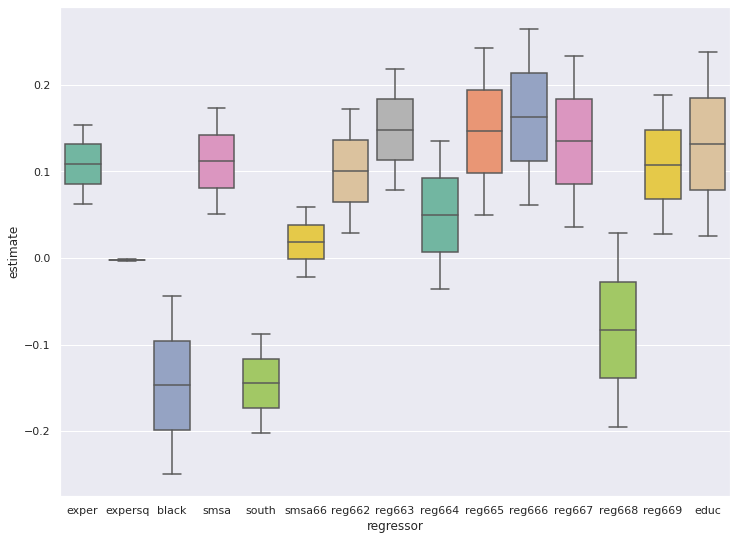

In [13]:
# Plot the upper and lower points using a boxplot

sns.boxplot(x="regressor", y="estimate", data=conf_int, palette="Set2")

# 3. Panel IV: 
## Do political differences between countries affect their tradeflows?
---

## Note:
- For copyright reasons, the dataset in this section differs from the one in Rachel Meager's R code.
- The following dataset contains data on tradeflows between countries from 1940-2018.

## Model:
- Let's test whether political differences (as measured by Polity scores) affect bilateral tradeflows between countries.
- Unit of interest is the annual trade relationship between two countries (e.g. NZL-AUS).
- I will look at **three different identification strategies for panel data**:
    - *Fixed Effects*
    - *Arellano-Bond Instrumental Variables*
    - *Anderson-Hsiao Instrumental Variables*
- Include physical distance and WTO membership between countries as controls.

### References:
- Dataset prepared by Christopher Lo (https://github.com/topher-lo/tradeflow-polity) 
- Original sources: 
    - Head et al (2010) "*The Erosion of Trade Linkages After Independence*" (https://sites.google.com/site/hiegravity/data-sources)
    - PolityV Annual Time Series 1946-2018 (https://www.systemicpeace.org/inscrdata.html)

In [14]:
# Import data
polity_data = pd.read_csv("https://media.githubusercontent.com/media/topher-lo/tradeflow-polity/master/data/trade-polity.csv", 
                          index_col=0).set_index(['tradelink','year'])

# Include a year column
polity_data['year'] = polity_data.index.get_level_values('year').astype('str')

# Include a tradelink column
polity_data['tradelink'] = polity_data.index.get_level_values('tradelink').astype('str')
polity_data

iso_o iso_d  contig  comlang_off         distw      pop_o  \
tradelink year                                                             
ARG-AGO   1990   ARG   AGO       0            0   7977.915823  32.580860   
AUS-AGO   1990   AUS   AGO       0            0  12954.905818  17.065100   
AUT-AGO   1990   AUT   AGO       0            0   6432.058253   7.710882   
BDI-AGO   1990   BDI   AGO       0            0   1905.419703   5.670250   
BEL-AGO   1990   BEL   AGO       0            0   6817.662686   9.967400   
...              ...   ...     ...          ...           ...        ...   
TWN-LUX   2002   TWN   LUX       0            0   9609.759792  22.400000   
          2003   TWN   LUX       0            0   9609.759792  22.490000   
          2004   TWN   LUX       0            0   9609.759792  22.580000   
          2005   TWN   LUX       0            0   9609.759792  22.650000   
          2006   TWN   LUX       0            0   9609.759792        NaN   

                      gdp_o     gdpcap_o iso2_o      pop_d  ...        flow  \
tradelink year                                              ...               
ARG-AGO   1990  141352.3800   4338.51000     AR  10.532123  ...   24.747800   
AUS-AGO   1990  319264.7000  18708.63300     AU  10.532123  ...    1.296240   
AUT-AGO   1990  164984.0300  21396.26000     AT  10.532123  ...    2.999282   
BDI-AGO   1990    1132.1012    199.65631     BI  10.532123  ...    0.000000   
BEL-AGO   1990  202690.9700  20335.39000     BE  10.532123  ...   76.786900   
...                     ...          ...    ...        ...  ...         ...   
TWN-LUX   2002  294803.0000  13160.84900     TW   0.443500  ...  637.017600   
          2003  299785.0000  13329.70200     TW   0.449947  ...  775.699000   
          2004  322179.0000  14268.33500     TW   0.453297  ...  485.395600   
          2005  345862.0000  15269.84600     TW   0.456710  ...  248.613600   
          2006          NaN          NaN     TW   0.462042  ...  254.657100   

                validmirror family  country_o   country_d  polity_o  polity_d  \
tradelink year                                                                  
ARG-AGO   1990            1    NaN  Argentina      Angola       7.0      -7.0   
AUS-AGO   1990            1    NaN  Australia      Angola      10.0      -7.0   
AUT-AGO   1990            1    NaN    Austria      Angola      10.0      -7.0   
BDI-AGO   1990            1    NaN    Burundi      Angola      -6.0      -7.0   
BEL-AGO   1990            1    NaN    Belgium      Angola      10.0      -7.0   
...                     ...    ...        ...         ...       ...       ...   
TWN-LUX   2002            0    NaN     Taiwan  Luxembourg       9.0      10.0   
          2003            0    NaN     Taiwan  Luxembourg       9.0      10.0   
          2004            0    NaN     Taiwan  Luxembourg      10.0      10.0   
          2005            0    NaN     Taiwan  Luxembourg      10.0      10.0   
          2006            0    NaN     Taiwan  Luxembourg      10.0      10.0   

                polity_dist  year  tradelink  
tradelink year                                
ARG-AGO   1990         14.0  1990    ARG-AGO  
AUS-AGO   1990         17.0  1990    AUS-AGO  
AUT-AGO   1990         17.0  1990    AUT-AGO  
BDI-AGO   1990          1.0  1990    BDI-AGO  
BEL-AGO   1990         17.0  1990    BEL-AGO  
...                     ...   ...        ...  
TWN-LUX   2002          1.0  2002    TWN-LUX  
          2003          1.0  2003    TWN-LUX  
          2004          0.0  2004    TWN-LUX  
          2005          0.0  2005    TWN-LUX  
          2006          0.0  2006    TWN-LUX  

[334442 rows x 42 columns]

In [15]:
# Create a column column of the sum of gdp_o and gdp_d

polity_data['gdp_dist'] = abs(polity_data['gdp_o'] - polity_data['gdp_d'])
polity_data

iso_o iso_d  contig  comlang_off         distw      pop_o  \
tradelink year                                                             
ARG-AGO   1990   ARG   AGO       0            0   7977.915823  32.580860   
AUS-AGO   1990   AUS   AGO       0            0  12954.905818  17.065100   
AUT-AGO   1990   AUT   AGO       0            0   6432.058253   7.710882   
BDI-AGO   1990   BDI   AGO       0            0   1905.419703   5.670250   
BEL-AGO   1990   BEL   AGO       0            0   6817.662686   9.967400   
...              ...   ...     ...          ...           ...        ...   
TWN-LUX   2002   TWN   LUX       0            0   9609.759792  22.400000   
          2003   TWN   LUX       0            0   9609.759792  22.490000   
          2004   TWN   LUX       0            0   9609.759792  22.580000   
          2005   TWN   LUX       0            0   9609.759792  22.650000   
          2006   TWN   LUX       0            0   9609.759792        NaN   

                      gdp_o     gdpcap_o iso2_o      pop_d  ...  validmirror  \
tradelink year                                              ...                
ARG-AGO   1990  141352.3800   4338.51000     AR  10.532123  ...            1   
AUS-AGO   1990  319264.7000  18708.63300     AU  10.532123  ...            1   
AUT-AGO   1990  164984.0300  21396.26000     AT  10.532123  ...            1   
BDI-AGO   1990    1132.1012    199.65631     BI  10.532123  ...            1   
BEL-AGO   1990  202690.9700  20335.39000     BE  10.532123  ...            1   
...                     ...          ...    ...        ...  ...          ...   
TWN-LUX   2002  294803.0000  13160.84900     TW   0.443500  ...            0   
          2003  299785.0000  13329.70200     TW   0.449947  ...            0   
          2004  322179.0000  14268.33500     TW   0.453297  ...            0   
          2005  345862.0000  15269.84600     TW   0.456710  ...            0   
          2006          NaN          NaN     TW   0.462042  ...            0   

                family  country_o   country_d  polity_o  polity_d  \
tradelink year                                                      
ARG-AGO   1990     NaN  Argentina      Angola       7.0      -7.0   
AUS-AGO   1990     NaN  Australia      Angola      10.0      -7.0   
AUT-AGO   1990     NaN    Austria      Angola      10.0      -7.0   
BDI-AGO   1990     NaN    Burundi      Angola      -6.0      -7.0   
BEL-AGO   1990     NaN    Belgium      Angola      10.0      -7.0   
...                ...        ...         ...       ...       ...   
TWN-LUX   2002     NaN     Taiwan  Luxembourg       9.0      10.0   
          2003     NaN     Taiwan  Luxembourg       9.0      10.0   
          2004     NaN     Taiwan  Luxembourg      10.0      10.0   
          2005     NaN     Taiwan  Luxembourg      10.0      10.0   
          2006     NaN     Taiwan  Luxembourg      10.0      10.0   

                polity_dist  year  tradelink     gdp_dist  
tradelink year                                             
ARG-AGO   1990         14.0  1990    ARG-AGO  131092.1870  
AUS-AGO   1990         17.0  1990    AUS-AGO  309004.5070  
AUT-AGO   1990         17.0  1990    AUT-AGO  154723.8370  
BDI-AGO   1990          1.0  1990    BDI-AGO    9128.0918  
BEL-AGO   1990         17.0  1990    BEL-AGO  192430.7770  
...                     ...   ...        ...          ...  
TWN-LUX   2002          1.0  2002    TWN-LUX  272190.3520  
          2003          1.0  2003    TWN-LUX  270796.5120  
          2004          0.0  2004    TWN-LUX  288586.1300  
          2005          0.0  2005    TWN-LUX  309393.2770  
          2006          0.0  2006    TWN-LUX          NaN  

[334442 rows x 43 columns]

In [16]:
# Create a column column of the sum of gdp_o and gdp_d

polity_data['gdp_dist'] = abs(polity_data['gdp_o'] - polity_data['gdp_d'])
polity_data

# WTO membership column
polity_data['wto'] = polity_data['gatt_o'] + polity_data['gatt_d']

In [17]:
# Drop missing values

polity_data = polity_data.dropna(subset=['gdp_dist', 'polity_dist'])
polity_data

iso_o iso_d  contig  comlang_off         distw      pop_o  \
tradelink year                                                             
ARG-AGO   1990   ARG   AGO       0            0   7977.915823  32.580860   
AUS-AGO   1990   AUS   AGO       0            0  12954.905818  17.065100   
AUT-AGO   1990   AUT   AGO       0            0   6432.058253   7.710882   
BDI-AGO   1990   BDI   AGO       0            0   1905.419703   5.670250   
BEL-AGO   1990   BEL   AGO       0            0   6817.662686   9.967400   
...              ...   ...     ...          ...           ...        ...   
TWN-LUX   2001   TWN   LUX       0            0   9609.759792  22.280000   
          2002   TWN   LUX       0            0   9609.759792  22.400000   
          2003   TWN   LUX       0            0   9609.759792  22.490000   
          2004   TWN   LUX       0            0   9609.759792  22.580000   
          2005   TWN   LUX       0            0   9609.759792  22.650000   

                      gdp_o     gdpcap_o iso2_o      pop_d  ...  family  \
tradelink year                                              ...           
ARG-AGO   1990  141352.3800   4338.51000     AR  10.532123  ...     NaN   
AUS-AGO   1990  319264.7000  18708.63300     AU  10.532123  ...     NaN   
AUT-AGO   1990  164984.0300  21396.26000     AT  10.532123  ...     NaN   
BDI-AGO   1990    1132.1012    199.65631     BI  10.532123  ...     NaN   
BEL-AGO   1990  202690.9700  20335.39000     BE  10.532123  ...     NaN   
...                     ...          ...    ...        ...  ...     ...   
TWN-LUX   2001  291694.0000  13092.18900     TW   0.439500  ...     NaN   
          2002  294803.0000  13160.84900     TW   0.443500  ...     NaN   
          2003  299785.0000  13329.70200     TW   0.449947  ...     NaN   
          2004  322179.0000  14268.33500     TW   0.453297  ...     NaN   
          2005  345862.0000  15269.84600     TW   0.456710  ...     NaN   

                country_o   country_d  polity_o  polity_d  polity_dist  year  \
tradelink year                                                                 
ARG-AGO   1990  Argentina      Angola       7.0      -7.0         14.0  1990   
AUS-AGO   1990  Australia      Angola      10.0      -7.0         17.0  1990   
AUT-AGO   1990    Austria      Angola      10.0      -7.0         17.0  1990   
BDI-AGO   1990    Burundi      Angola      -6.0      -7.0          1.0  1990   
BEL-AGO   1990    Belgium      Angola      10.0      -7.0         17.0  1990   
...                   ...         ...       ...       ...          ...   ...   
TWN-LUX   2001     Taiwan  Luxembourg       9.0      10.0          1.0  2001   
          2002     Taiwan  Luxembourg       9.0      10.0          1.0  2002   
          2003     Taiwan  Luxembourg       9.0      10.0          1.0  2003   
          2004     Taiwan  Luxembourg      10.0      10.0          0.0  2004   
          2005     Taiwan  Luxembourg      10.0      10.0          0.0  2005   

                tradelink     gdp_dist  wto  
tradelink year                               
ARG-AGO   1990    ARG-AGO  131092.1870    1  
AUS-AGO   1990    AUS-AGO  309004.5070    1  
AUT-AGO   1990    AUT-AGO  154723.8370    1  
BDI-AGO   1990    BDI-AGO    9128.0918    1  
BEL-AGO   1990    BEL-AGO  192430.7770    1  
...                   ...          ...  ...  
TWN-LUX   2001    TWN-LUX  271495.0740    1  
          2002    TWN-LUX  272190.3520    2  
          2003    TWN-LUX  270796.5120    2  
          2004    TWN-LUX  288586.1300    2  
          2005    TWN-LUX  309393.2770    2  

[304700 rows x 44 columns]

In [18]:
# Write function that returns original dataframe with additional lags for a specified col
# Patsy in Python does not have a lag operator to use in formulas

def get_lags(data, col, lag, level=0):
    for i in range(lag):
        data.loc[:, f'{col}_{i+1}'] = data.groupby(level=level)[col].shift(i+1)
    return data

In [19]:
# Create 3 lags of total_gdp

n_gdp_lags = 3 
get_lags(polity_data, 'gdp_dist', n_gdp_lags)

/home/topher-lo/repos/PyEC333/ec333_env/lib/python3.8/site-packages/pandas/core/indexing.py:1597: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = value
/home/topher-lo/repos/PyEC333/ec333_env/lib/python3.8/site-packages/pandas/core/indexing.py:1676: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(ilocs[0], value, pi)


iso_o iso_d  contig  comlang_off         distw      pop_o  \
tradelink year                                                             
ARG-AGO   1990   ARG   AGO       0            0   7977.915823  32.580860   
AUS-AGO   1990   AUS   AGO       0            0  12954.905818  17.065100   
AUT-AGO   1990   AUT   AGO       0            0   6432.058253   7.710882   
BDI-AGO   1990   BDI   AGO       0            0   1905.419703   5.670250   
BEL-AGO   1990   BEL   AGO       0            0   6817.662686   9.967400   
...              ...   ...     ...          ...           ...        ...   
TWN-LUX   2001   TWN   LUX       0            0   9609.759792  22.280000   
          2002   TWN   LUX       0            0   9609.759792  22.400000   
          2003   TWN   LUX       0            0   9609.759792  22.490000   
          2004   TWN   LUX       0            0   9609.759792  22.580000   
          2005   TWN   LUX       0            0   9609.759792  22.650000   

                      gdp_o     gdpcap_o iso2_o      pop_d  ...  polity_o  \
tradelink year                                              ...             
ARG-AGO   1990  141352.3800   4338.51000     AR  10.532123  ...       7.0   
AUS-AGO   1990  319264.7000  18708.63300     AU  10.532123  ...      10.0   
AUT-AGO   1990  164984.0300  21396.26000     AT  10.532123  ...      10.0   
BDI-AGO   1990    1132.1012    199.65631     BI  10.532123  ...      -6.0   
BEL-AGO   1990  202690.9700  20335.39000     BE  10.532123  ...      10.0   
...                     ...          ...    ...        ...  ...       ...   
TWN-LUX   2001  291694.0000  13092.18900     TW   0.439500  ...       9.0   
          2002  294803.0000  13160.84900     TW   0.443500  ...       9.0   
          2003  299785.0000  13329.70200     TW   0.449947  ...       9.0   
          2004  322179.0000  14268.33500     TW   0.453297  ...      10.0   
          2005  345862.0000  15269.84600     TW   0.456710  ...      10.0   

                polity_d polity_dist  year  tradelink     gdp_dist  wto  \
tradelink year                                                            
ARG-AGO   1990      -7.0        14.0  1990    ARG-AGO  131092.1870    1   
AUS-AGO   1990      -7.0        17.0  1990    AUS-AGO  309004.5070    1   
AUT-AGO   1990      -7.0        17.0  1990    AUT-AGO  154723.8370    1   
BDI-AGO   1990      -7.0         1.0  1990    BDI-AGO    9128.0918    1   
BEL-AGO   1990      -7.0        17.0  1990    BEL-AGO  192430.7770    1   
...                  ...         ...   ...        ...          ...  ...   
TWN-LUX   2001      10.0         1.0  2001    TWN-LUX  271495.0740    1   
          2002      10.0         1.0  2002    TWN-LUX  272190.3520    2   
          2003      10.0         1.0  2003    TWN-LUX  270796.5120    2   
          2004      10.0         0.0  2004    TWN-LUX  288586.1300    2   
          2005      10.0         0.0  2005    TWN-LUX  309393.2770    2   

                gdp_dist_1  gdp_dist_2  gdp_dist_3  
tradelink year                                      
ARG-AGO   1990         NaN         NaN         NaN  
AUS-AGO   1990         NaN         NaN         NaN  
AUT-AGO   1990         NaN         NaN         NaN  
BDI-AGO   1990         NaN         NaN         NaN  
BEL-AGO   1990         NaN         NaN         NaN  
...                    ...         ...         ...  
TWN-LUX   2001  300960.422  277569.273  256751.145  
          2002  271495.074  300960.422  277569.273  
          2003  272190.352  271495.074  300960.422  
          2004  270796.512  272190.352  271495.074  
          2005  288586.130  270796.512  272190.352  

[304700 rows x 47 columns]

In [20]:
# Create 99 lags of polity_dist

get_lags(polity_data, 'polity_dist', 99)

/home/topher-lo/repos/PyEC333/ec333_env/lib/python3.8/site-packages/pandas/core/indexing.py:1597: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = value
/home/topher-lo/repos/PyEC333/ec333_env/lib/python3.8/site-packages/pandas/core/indexing.py:1676: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(ilocs[0], value, pi)


iso_o iso_d  contig  comlang_off         distw      pop_o  \
tradelink year                                                             
ARG-AGO   1990   ARG   AGO       0            0   7977.915823  32.580860   
AUS-AGO   1990   AUS   AGO       0            0  12954.905818  17.065100   
AUT-AGO   1990   AUT   AGO       0            0   6432.058253   7.710882   
BDI-AGO   1990   BDI   AGO       0            0   1905.419703   5.670250   
BEL-AGO   1990   BEL   AGO       0            0   6817.662686   9.967400   
...              ...   ...     ...          ...           ...        ...   
TWN-LUX   2001   TWN   LUX       0            0   9609.759792  22.280000   
          2002   TWN   LUX       0            0   9609.759792  22.400000   
          2003   TWN   LUX       0            0   9609.759792  22.490000   
          2004   TWN   LUX       0            0   9609.759792  22.580000   
          2005   TWN   LUX       0            0   9609.759792  22.650000   

                      gdp_o     gdpcap_o iso2_o      pop_d  ...  \
tradelink year                                              ...   
ARG-AGO   1990  141352.3800   4338.51000     AR  10.532123  ...   
AUS-AGO   1990  319264.7000  18708.63300     AU  10.532123  ...   
AUT-AGO   1990  164984.0300  21396.26000     AT  10.532123  ...   
BDI-AGO   1990    1132.1012    199.65631     BI  10.532123  ...   
BEL-AGO   1990  202690.9700  20335.39000     BE  10.532123  ...   
...                     ...          ...    ...        ...  ...   
TWN-LUX   2001  291694.0000  13092.18900     TW   0.439500  ...   
          2002  294803.0000  13160.84900     TW   0.443500  ...   
          2003  299785.0000  13329.70200     TW   0.449947  ...   
          2004  322179.0000  14268.33500     TW   0.453297  ...   
          2005  345862.0000  15269.84600     TW   0.456710  ...   

                polity_dist_90  polity_dist_91 polity_dist_92  polity_dist_93  \
tradelink year                                                                  
ARG-AGO   1990             NaN             NaN            NaN             NaN   
AUS-AGO   1990             NaN             NaN            NaN             NaN   
AUT-AGO   1990             NaN             NaN            NaN             NaN   
BDI-AGO   1990             NaN             NaN            NaN             NaN   
BEL-AGO   1990             NaN             NaN            NaN             NaN   
...                        ...             ...            ...             ...   
TWN-LUX   2001             NaN             NaN            NaN             NaN   
          2002             NaN             NaN            NaN             NaN   
          2003             NaN             NaN            NaN             NaN   
          2004             NaN             NaN            NaN             NaN   
          2005             NaN             NaN            NaN             NaN   

                polity_dist_94  polity_dist_95  polity_dist_96  \
tradelink year                                                   
ARG-AGO   1990             NaN             NaN             NaN   
AUS-AGO   1990             NaN             NaN             NaN   
AUT-AGO   1990             NaN             NaN             NaN   
BDI-AGO   1990             NaN             NaN             NaN   
BEL-AGO   1990             NaN             NaN             NaN   
...                        ...             ...             ...   
TWN-LUX   2001             NaN             NaN             NaN   
          2002             NaN             NaN             NaN   
          2003             NaN             NaN             NaN   
          2004             NaN             NaN             NaN   
          2005             NaN             NaN             NaN   

                polity_dist_97  polity_dist_98  polity_dist_99  
tradelink year                                                  
ARG-AGO   1990             NaN             NaN             NaN  
AUS-AGO   1990             NaN             NaN

In [21]:
polity_data = polity_data.fillna(0)

## 3.1. Pooled OLS

In [22]:
# Naive OLS assuming i.i.d. data
# Remember! range(start, end) is an iterator for start, start + 1, ..., end - 1

gdp_lags = '+'.join([f'gdp_dist_{i}' for i in range(1, 3)])
formula_OLS = f'flow ~ {gdp_lags} + polity_dist + distw + wto'
mod_OLS = PooledOLS.from_formula(formula_OLS, data=polity_data)
res_OLS = mod_OLS.fit(cov_type="clustered", cluster_entity=True)
res_OLS.summary

Dep. Variable:,flow,R-squared:,0.0651
Estimator:,PooledOLS,R-squared (Between):,0.0697
No. Observations:,304700,R-squared (Within):,0.0215
Date:,"Thu, Mar 11 2021",R-squared (Overall):,0.0651
Time:,11:04:57,Log-likelihood,-2.924e+06
Cov. Estimator:,Clustered,,
,,F-statistic:,4245.6
Entities:,21419,P-value,0.0000
Avg Obs:,14.226,Distribution:,"F(5,304695)"
Min Obs:,0.0000,,
Max Obs:,18.000,F-statistic (robust):,70.709


## 3.2. Fixed Effects

In [23]:
# Two-way fixed effects
# Note: we removed the distw covariate because it is captured in EntityEffects

formula_fe = f'flow ~ polity_dist + EntityEffects + TimeEffects'
mod_fe = PanelOLS.from_formula(formula_fe, data=polity_data)
res_fe = mod_fe.fit(cov_type="clustered", cluster_entity=True)
res_fe.summary

Dep. Variable:,flow,R-squared:,2.759e-05
Estimator:,PanelOLS,R-squared (Between):,0.0006
No. Observations:,304700,R-squared (Within):,-0.0001
Date:,"Thu, Mar 11 2021",R-squared (Overall):,0.0005
Time:,11:05:02,Log-likelihood,-2.632e+06
Cov. Estimator:,Clustered,,
,,F-statistic:,7.8285
Entities:,21419,P-value,0.0051
Avg Obs:,14.226,Distribution:,"F(1,283701)"
Min Obs:,0.0000,,
Max Obs:,18.000,F-statistic (robust):,2.6767


## 3.4. Anderson-Hsiao Panel IV 

In [24]:
# Anderson-Hsiao
# Following Rachel Meager's code, let's use 2-step efficient GMM to fit the A.H. model

formula_ah = f'flow ~ {gdp_lags} + [polity_dist ~ polity_dist_1] + distw + wto'
mod_ah = IVGMM.from_formula(formula_ah, data=polity_data)
res_ah = mod_ah.fit()
res_ah.summary

<class 'linearmodels.compat.statsmodels.Summary'>
"""
                          IV-GMM Estimation Summary                           
==============================================================================
Dep. Variable:                   flow   R-squared:                      0.0650
Estimator:                     IV-GMM   Adj. R-squared:                 0.0650
No. Observations:              304700   F-statistic:                    4590.2
Date:                Thu, Mar 11 2021   P-value (F-stat)                0.0000
Time:                        11:05:04   Distribution:                  chi2(5)
Cov. Estimator:                robust                                         
                                                                              
                              Parameter Estimates                              
===============================================================================
             Parameter  Std. Err.     T-stat    P-value    Lower CI    Upper CI
-------------------------------------------------------------------------------
gdp_dist_1      0.0005  5.791e-05     9.3365     0.0000      0.0004      0.0007
gdp_dist_2      0.0001  6.407e-05     2.2045     0.0275   1.567e-05      0.0003
distw          -0.0539     0.0018    -29.347     0.0000     -0.0575     -0.0503
wto             404.16     10.191     39.658     0.0000      384.18      424.13
polity_dist    -25.029     1.1880    -21.069     0.0000     -27.357     -22.701
===============================================================================

Endogenous: polity_dist
Instruments: polity_dist_1
GMM Covariance
Debiased: False
Robust (Heteroskedastic)
"""

In [25]:
# First Stage Diagnostics

formula_ah_first = f'polity_dist ~ polity_dist_1 + {gdp_lags} + distw + wto'
mod_ah_first = IVGMM.from_formula(formula_ah_first, data=polity_data)
res_ah_first = mod_ah_first.fit()
res_ah_first.summary

<class 'linearmodels.compat.statsmodels.Summary'>
"""
                          IV-GMM Estimation Summary                           
==============================================================================
Dep. Variable:            polity_dist   R-squared:                      0.7217
Estimator:                     IV-GMM   Adj. R-squared:                 0.7217
No. Observations:              304700   F-statistic:                 8.696e+05
Date:                Thu, Mar 11 2021   P-value (F-stat)                0.0000
Time:                        11:05:05   Distribution:                  chi2(5)
Cov. Estimator:                robust                                         
                                                                              
                               Parameter Estimates                               
=================================================================================
               Parameter  Std. Err.     T-stat    P-value    Lower CI    Upper CI
---------------------------------------------------------------------------------
Intercept         2.7631     0.0237     116.71     0.0000      2.7167      2.8095
polity_dist_1     0.8252     0.0011     784.08     0.0000      0.8231      0.8272
gdp_dist_1    -2.348e-07  1.768e-08    -13.279     0.0000  -2.695e-07  -2.002e-07
gdp_dist_2     1.312e-07   1.85e-08     7.0894     0.0000    9.49e-08   1.674e-07
distw          1.477e-05  1.275e-06     11.583     0.0000   1.227e-05   1.727e-05
wto              -0.7479     0.0106    -70.290     0.0000     -0.7687     -0.7270
=================================================================================
"""

## 3.5. Arellano-Bond Panel IV 

In [26]:
# Arellano-Bond
# Following Rachel Meager's code, let's use 2-step efficient GMM to fit the A.B. model

n_lags = 10
polity_lags = '+'.join([f'polity_dist_{i}' for i in range(1, n_lags+1)])
formula_ab = f'flow ~ {gdp_lags} + [polity_dist ~ {polity_lags}] + distw + wto'
mod_ab = IVGMM.from_formula(formula_ab, data=polity_data)
res_ab = mod_ab.fit()
res_ab.summary

<class 'linearmodels.compat.statsmodels.Summary'>
"""
                          IV-GMM Estimation Summary                           
==============================================================================
Dep. Variable:                   flow   R-squared:                      0.0587
Estimator:                     IV-GMM   Adj. R-squared:                 0.0587
No. Observations:              304700   F-statistic:                    4611.1
Date:                Thu, Mar 11 2021   P-value (F-stat)                0.0000
Time:                        11:05:08   Distribution:                  chi2(5)
Cov. Estimator:                robust                                         
                                                                              
                              Parameter Estimates                              
===============================================================================
             Parameter  Std. Err.     T-stat    P-value    Lower CI    Upper CI
-------------------------------------------------------------------------------
gdp_dist_1      0.0007  4.476e-05     15.230     0.0000      0.0006      0.0008
gdp_dist_2     -0.0003  3.559e-05    -7.0809     0.0000     -0.0003     -0.0002
distw          -0.0411     0.0016    -26.167     0.0000     -0.0441     -0.0380
wto             328.26     8.2128     39.969     0.0000      312.16      344.36
polity_dist    -14.246     0.6941    -20.524     0.0000     -15.606     -12.885
===============================================================================

Endogenous: polity_dist
Instruments: polity_dist_1, polity_dist_2, polity_dist_3, polity_dist_4, polity_dist_5, polity_dist_6, polity_dist_7, polity_dist_8, polity_dist_9, polity_dist_10
GMM Covariance
Debiased: False
Robust (Heteroskedastic)
"""

In [27]:
# First Stage Diagnostics

formula_ah_first = f'polity_dist ~ {polity_lags} + {gdp_lags} + distw + wto'
mod_ah_first = IVGMM.from_formula(formula_ah_first, data=polity_data)
res_ah_first = mod_ah_first.fit()
res_ah_first.summary

<class 'linearmodels.compat.statsmodels.Summary'>
"""
                          IV-GMM Estimation Summary                           
==============================================================================
Dep. Variable:            polity_dist   R-squared:                      0.7219
Estimator:                     IV-GMM   Adj. R-squared:                 0.7218
No. Observations:              304700   F-statistic:                 8.847e+05
Date:                Thu, Mar 11 2021   P-value (F-stat)                0.0000
Time:                        11:05:14   Distribution:                 chi2(14)
Cov. Estimator:                robust                                         
                                                                              
                               Parameter Estimates                                
==================================================================================
                Parameter  Std. Err.     T-stat    P-value    Lower CI    Upper CI
----------------------------------------------------------------------------------
Intercept          2.7666     0.0237     116.80     0.0000      2.7202      2.8130
polity_dist_1      0.8258     0.0018     459.99     0.0000      0.8223      0.8294
polity_dist_2     -0.0016     0.0021    -0.7497     0.4535     -0.0058      0.0026
polity_dist_3     -0.0099     0.0018    -5.4181     0.0000     -0.0135     -0.0063
polity_dist_4      0.0008     0.0019     0.4393     0.6604     -0.0028      0.0044
polity_dist_5      0.0141     0.0017     8.0743     0.0000      0.0107      0.0175
polity_dist_6      0.0130     0.0016     8.1009     0.0000      0.0099      0.0162
polity_dist_7     -0.0216     0.0018    -11.717     0.0000     -0.0252     -0.0180
polity_dist_8      0.0046     0.0017     2.7272     0.0064      0.0013      0.0079
polity_dist_9     -0.0080     0.0016    -4.8897     0.0000     -0.0112     -0.0048
polity_dist_10     0.0128     0.0014     9.0509     0.0000      0.0100      0.0156
gdp_dist_1     -2.395e-07  1.797e-08    -13.323     0.0000  -2.747e-07  -2.042e-07
gdp_dist_2      1.346e-07  1.876e-08     7.1744     0.0000   9.785e-08   1.714e-07
distw           1.479e-05  1.274e-06     11.612     0.0000    1.23e-05   1.729e-05
wto               -0.7550     0.0108    -69.874     0.0000     -0.7762     -0.7338
==================================================================================
"""